# Question Answering

Como hemos visto en la teoría, la arquitectura de para un question answering consiste en un módulo de generación que se implementa con un LLM. Vamos a construir dos modelos que generen respuestas a ciertas preguntas, y vamos a analizar el impacto de introducir contexto.






## Generadores de respuestas

In [ ]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

In [ ]:
import torch
device_setup = ("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device_setup)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### LLMs como generadores

In [ ]:
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM


warnings.filterwarnings("ignore", category=UserWarning, module="transformers.pytorch_utils")

class LLMModel:

    def __init__(self, model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0", cache_dir="./models/TinyLlama-1.1B-Chat-v1.0"):
        global device_setup
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype = torch.float32 if device_setup == "mps" else (torch.float16 if torch.cuda.is_available() else torch.float32),
            cache_dir=cache_dir,
            local_files_only=False
        ).to(device_setup)

    def __answer_with_model(self, prompt, do_sample, temperature, top_p, max_length, show_prompt):
        global device_setup
        formatted_prompt = self.tokenizer.apply_chat_template(conversation=prompt, tokenize=False, return_dict=False,  add_generation_prompt=True)

        # Tokenizar
        inputs = self.tokenizer(formatted_prompt, truncation=True, max_length=max_length,return_tensors="pt")
        inputs = {k: v.to(device_setup) for k, v in inputs.items()}

         # Muestra infomacion de log
        if show_prompt:
          print(formatted_prompt)
          print("--- Token size: ---")
          [print("\t", k, ": ", len(v[0])) for k, v in inputs.items()]
          print("-------------------")

        # Generar respuesta
        outputs = self.model.generate(
            **inputs,
            temperature=temperature,
            top_p=top_p,
            do_sample=do_sample,
            pad_token_id=self.tokenizer.eos_token_id
        )

        # Decodificar y limpiar respuesta
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Limpiar la respuesta para que no aparezca el prompt
        return response.split("<|assistant|>")[1].strip()

    def __get_nocontext_prompt(self, query):
        return [
            {
                "role": "system",
                "content": "Give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If you don't know the answer respond with 'I do not know the answer'.",
            },
            {"role": "user", "content": "Answer the following question: " + query + "\n"},
        ]

    def __get_context_prompt(self, query, context=""):
        context = "" if not context else context
        return [{
            "role": "system",
            "content": "Use the following context to answer the question concisely and accurately. If the answer cannot be deduced from the context, do not answer the question and just say 'I do not know'. If you can answer with yes or no prioritize short answers.",
        },
        {"role": "user", "content": "Considering the following information:\n"+'\n'.join(context)+"\n answer to this question: "+query+"\n"}
    ]

    def answer(self, query, context, use_context=False, do_sample=True, temperature=0.1,
               top_p=0.9, max_length=2047, show_prompt=False):
        prompt = self.__get_context_prompt(query, context) if use_context or use_context else self.__get_nocontext_prompt(query)
        return self.__answer_with_model(prompt, do_sample, temperature, top_p, max_length, show_prompt)



In [25]:
# https://huggingface.co/datasets/rag-datasets/rag-mini-wikipedia
model =  LLMModel()
models = [
    ("TinyLlama-1-NC", model, False),
    ("TinyLlama-2-C", model, True)
]
context = [
    "Abraham Lincoln (February 12, 1809 – April 15, 1865) was the 16th president of the United States, serving from 1861 until his assassination in 1865. He led the United States through the American Civil War, defending the nation as a constitutional union, defeating the Confederacy, playing a major role in the abolition of slavery, expanding the power of the federal government, and modernizing the U.S. economy."
    ]

queries = ["Was Abraham Lincoln the sixteenth President of the United States?", "Did Lincoln sign the National Banking Act of 1863?"]


for query in queries:
    for model_name, model, context_usage  in models:
        # Generar respuesta del modelo
        answer = model.answer(query=query, context=context, use_context=context_usage)
        print("Context usage: ", context_usage)
        print(">", model_name, ": ", answer)
        print("**********")


Context usage:  False
> TinyLlama-1-NC :  Yes, Abraham Lincoln was the sixteenth President of the United States.
**********
Context usage:  True
> TinyLlama-2-C :  Yes, Abraham Lincoln was the sixteenth President of the United States.
**********
Context usage:  False
> TinyLlama-1-NC :  Yes, Lincoln signed the National Banking Act of 1863. The act was passed by Congress in response to the Panic of 1863, which led to a decline in banking activity and a rise in bank failures. The act created the National Banking System, which was designed to regulate and stabilize the banking industry. Lincoln signed the act on March 3, 1863, and it became law on March 2, 1863.
**********
Context usage:  True
> TinyLlama-2-C :  Yes, Abraham Lincoln signed the National Banking Act of 1863. This act was passed by Congress in response to the growing financial crisis caused by the Civil War and the subsequent economic downturn. The act established the United States Bank, which was responsible for regulating 

In [26]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "covidqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 1:
        break

model = LLMModel()
models = [
    ("TinyLlama-1-NC", model, False),
    ("TinyLlama-2-C", model, True)
]


for raw_row in dataset:
  print("query: ", raw_row['question'])
  print("expected: ", raw_row['answer'])
  print("--------------------")
  for model_name, model, context_usage in models:
    answer = model.answer(query=raw_row['question'], context=raw_row['documents'], use_context=context_usage, show_prompt=True)
    print("\t>Context: ", context_usage)
    print("\t>", model_name, ": ", answer)
    print("**********")
  print("#######################")


query:  Which viruses may not cause prolonged inflammation due to strong induction of antiviral clearance?
expected:  The viruses that may not cause prolonged inflammation due to strong induction of antiviral clearance are murine norovirus, human astrovirus, and murine cytomegalovirus.
--------------------
<|system|>
Give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If you don't know the answer respond with 'I do not know the answer'.</s>
<|user|>
Answer the following question: Which viruses may not cause prolonged inflammation due to strong induction of antiviral clearance?
</s>
<|assistant|>

--- Token size: ---
	 input_ids :  101
	 attention_mask :  101
-------------------
	>Context:  False
	> TinyLlama-1-NC :  The viruses listed below do not cause prolonged inflammation due to strong induction of antiviral clearance:

1. Herpes simplex virus (HSV)
2. Epstein-Barr virus (EBV)
3. Human immunodefic

### Evaluar sistemas de question answering

1. Exact Match (EM)
 * Qué mide: Si la respuesta generada coincide exactamente con el gold standard.
 * Ventaja: Es fácil de interpretar.
 * Desventaja: Es muy estricta, ya que no considera sinónimos, parafraseos o respuestas parcialmente correctas.
 * Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States."
Gold Standard: "Yes" Resultado: No hay match exacto.*
2. F1-Score
* Qué mide: La similitud entre las palabras de la respuesta generada y las del gold standard en términos de precisión y recall.
* Precisión: Proporción de palabras generadas que son correctas.
* Recall: Proporción de palabras correctas del gold standard capturadas en la respuesta.
* Ventaja: Tolera parafraseos y respuestas parciales.
* Desventaja: Ignora el orden de las palabras.
* Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President."  Gold Standard: "Yes" Resultado: Precisión alta, pero recall puede ser bajo.*
3. BLEU (Bilingual Evaluation Understudy)
* Qué mide: Coincidencias en n-gramas entre la respuesta generada y el gold standard. Evalúa secuencias de palabras en lugar de palabras individuales.
* Ventaja: Considera el orden de las palabras.
* Desventaja: Fue diseñado para traducción, no QA; no siempre captura la calidad semántica.
* Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States."
Gold Standard: "Yes" Resultado: BLEU bajo debido a pocas coincidencias en n-gramas.*
4. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
* Qué mide: Coincidencias de n-gramas y recall.
* Variantes populares:
    * ROUGE-1: Coincidencias de palabras.
    * ROUGE-2: Coincidencias de bi-gramas.
    * ROUGE-L: Coincidencias en la subsecuencia común más larga (longest common subsequence).
* Ventaja: Útil para evaluar respuestas más largas o con paráfrasis.
* Desventaja: No mide la semántica.
* Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President." Gold Standard: "Yes" Resultado: ROUGE-1 puede ser alto, pero ROUGE-2 bajo.*
5. METEOR (Metric for Evaluation of Translation with Explicit ORdering)
* Qué mide: Coincidencias en palabras exactas, sinónimos y orden de palabras. Incluye aspectos de precisión, recall y alineación de palabras.
* Ventaja: Captura variaciones léxicas como sinónimos.
* Desventaja: No siempre refleja la semántica general.
* Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President." Gold Standard: "Yes" Resultado: METEOR considera las palabras coincidentes y podría ser razonablemente alto.*
6. Cosine Similarity (TF-IDF o Embeddings)
* Qué mide: Similitud semántica entre la respuesta generada y el gold standard. Usa representaciones vectoriales de los textos.
* Ventaja: Evalúa el significado general más allá de palabras exactas.* Desventaja: Puede ser insensible a detalles específicos como el formato de la respuesta.
* Ejemplo: *Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States." Gold Standard: "Yes" Resultado: Alta similitud si los vectores semánticos son similares.*

In [27]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import warnings
import nltk
nltk.download('wordnet')

def evaluate_qa_system(models, dataset):
    results_by_model = {}

    # Métricas y helpers
    vectorizer = TfidfVectorizer()
    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    for model_name, model, context_usage in models:
        metrics = {
            "bleu": [],
            "rouge": {"rouge1": [], "rouge2": [], "rougeL": []},
            "meteor": [],
            "exact_match": [],
            "f1": [],
            "cosine_similarity": []
        }

        for entry in dataset:
            query = entry["question"]
            context = entry["documents"]
            ground_truth = entry["answer"]

            # Respuesta del modelo
            prediction = model.answer(query=query, context=context, use_context=context_usage)

            # BLEU
            smoothing_function = SmoothingFunction()
            bleu_score = sentence_bleu([ground_truth.split()], prediction.split(), smoothing_function=smoothing_function.method1)
            metrics["bleu"].append(bleu_score)

            # ROUGE
            rouge_scores = rouge_scorer_obj.score(ground_truth, prediction)
            for rouge_metric in ["rouge1", "rouge2", "rougeL"]:
                metrics["rouge"][rouge_metric].append(rouge_scores[rouge_metric].fmeasure)

            # METEOR
            meteor = meteor_score([ground_truth.split()], prediction.split())
            metrics["meteor"].append(meteor)

            # Exact Match
            exact_match = int(prediction.strip() == ground_truth.strip())
            metrics["exact_match"].append(exact_match)

            # F1 Score
            y_true = set(ground_truth.split())
            y_pred = set(prediction.split())
            common = y_true & y_pred
            precision = len(common) / len(y_pred) if y_pred else 0
            recall = len(common) / len(y_true) if y_true else 0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
            metrics["f1"].append(f1)

            # Cosine Similarity
            tfidf_matrix = vectorizer.fit_transform([ground_truth, prediction])
            cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            metrics["cosine_similarity"].append(cosine_sim)

        # Promediar resultados
        avg_metrics = {
            "bleu": np.mean(metrics["bleu"]),
            "rouge": {k: np.mean(v) for k, v in metrics["rouge"].items()},
            "meteor": np.mean(metrics["meteor"]),
            "exact_match": np.mean(metrics["exact_match"]),
            "f1": np.mean(metrics["f1"]),
            "cosine_similarity": np.mean(metrics["cosine_similarity"])
        }
        results_by_model[model_name] = avg_metrics

    return results_by_model

def plot_evaluation_results(results_by_model):
    metrics = ["bleu", "meteor", "exact_match", "f1", "cosine_similarity"]
    models = list(results_by_model.keys())

    for metric in metrics:
        values = [results_by_model[model][metric] for model in models]
        plt.figure()
        plt.bar(models, values)
        plt.title(f"Comparación de {metric.capitalize()}")
        plt.xlabel("Modelos")
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Evaluación con basada en benchmark

Resultados para  TinyLlama-1-NC
bleu :  0.03690845307400126
rouge :  {'rouge1': 0.21789651203278218, 'rouge2': 0.1250530242366022, 'rougeL': 0.19806490560899698}
meteor :  0.24362118415221082
exact_match :  0.0
f1 :  0.22883153535769596
cosine_similarity :  0.26463526157626566
Resultados para  TinyLlama-2-C
bleu :  0.16141692418837356
rouge :  {'rouge1': 0.3954066341672908, 'rouge2': 0.26400886686700986, 'rougeL': 0.34821611916739365}
meteor :  0.4013324313680805
exact_match :  0.0
f1 :  0.3776257774607847
cosine_similarity :  0.4352595974602302


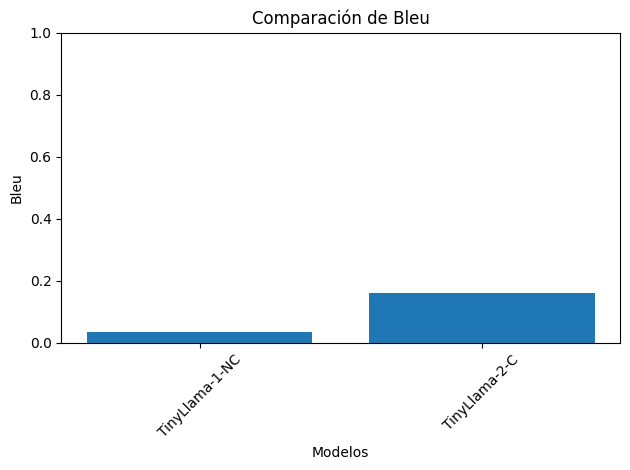

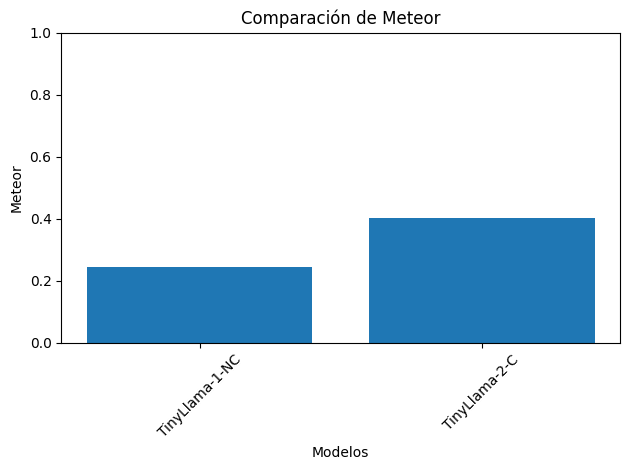

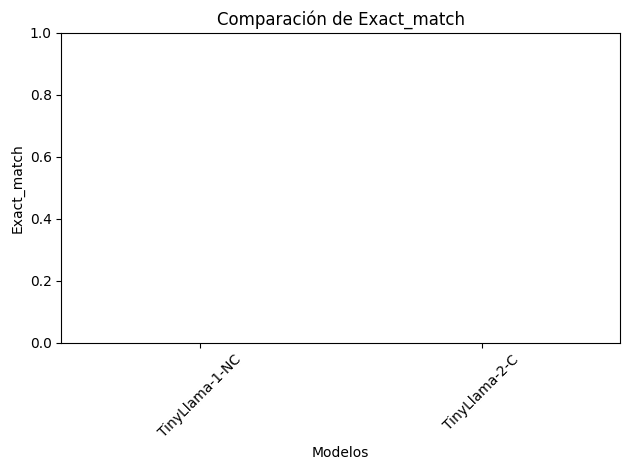

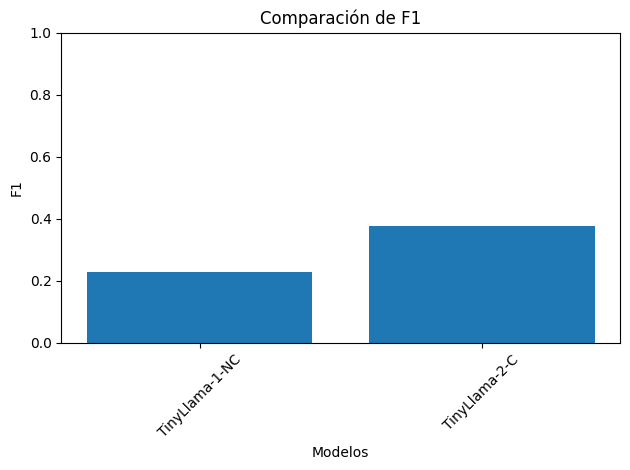

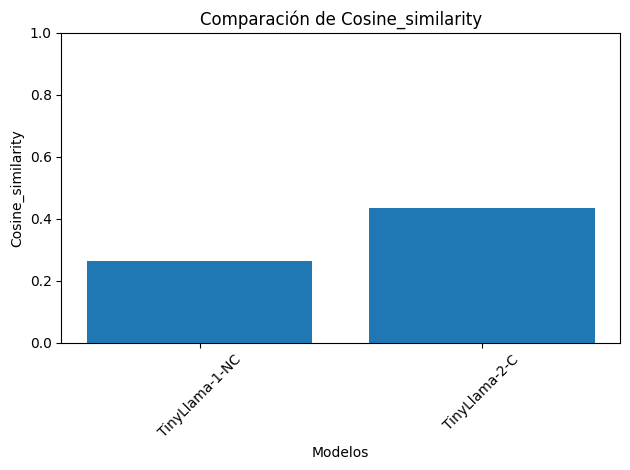

In [28]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "covidqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break

model = LLMModel()
models = [
    ("TinyLlama-1-NC", model, False),
    ("TinyLlama-2-C", model, True)
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)

Resultados para  TinyLlama-1-NC
bleu :  0.06482175933485679
rouge :  {'rouge1': 0.2538081935708948, 'rouge2': 0.10481402237284713, 'rougeL': 0.21456841854503056}
meteor :  0.2605191814600877
exact_match :  0.0
f1 :  0.25892291803634027
cosine_similarity :  0.38891538265731856
Resultados para  TinyLlama-2-C
bleu :  0.08928188111404209
rouge :  {'rouge1': 0.2456160480127544, 'rouge2': 0.17879913130945252, 'rougeL': 0.211483163350429}
meteor :  0.3830005392669956
exact_match :  0.0
f1 :  0.35981108573925435
cosine_similarity :  0.6091072184276556


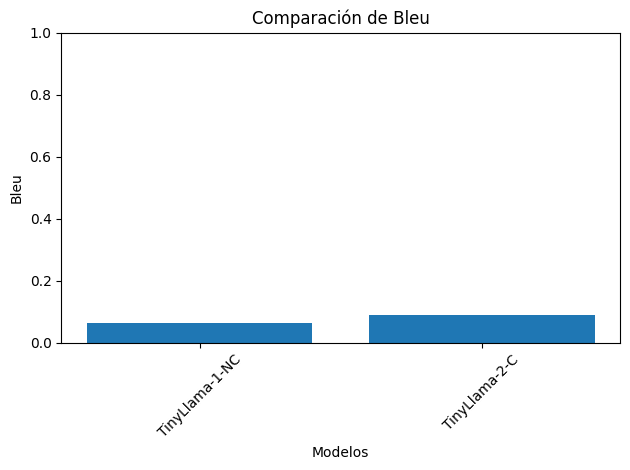

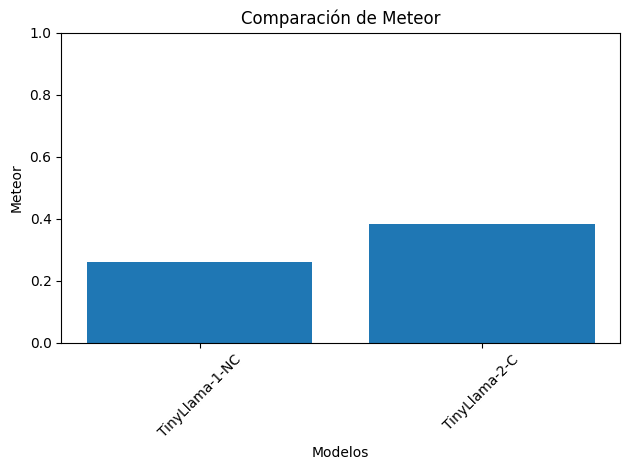

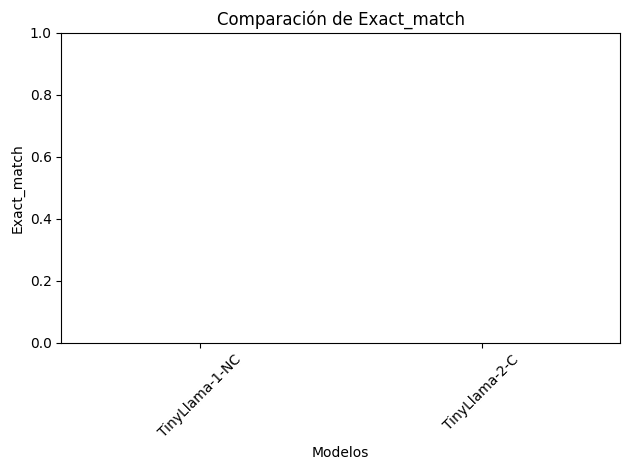

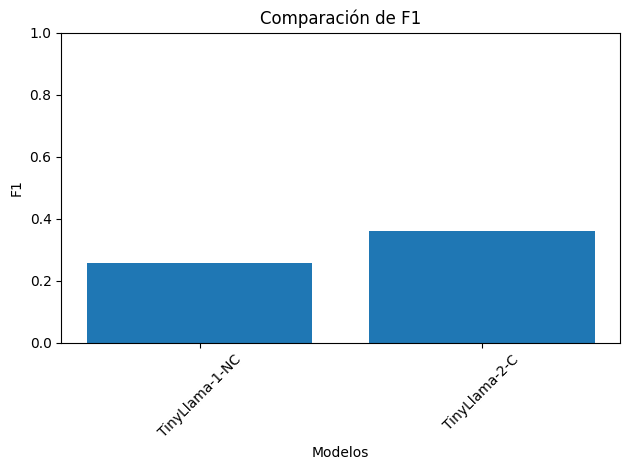

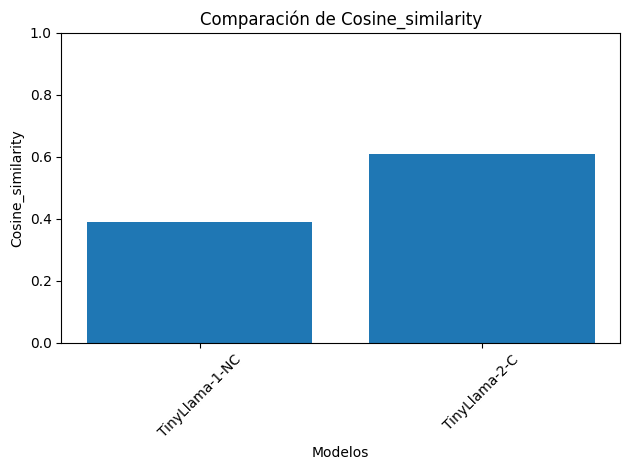

In [29]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "delucionqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break

model = LLMModel()
models = [
    ("TinyLlama-1-NC", model, False),
    ("TinyLlama-2-C", model, True)
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)

Resultados para  TinyLlama-1-NC
bleu :  0.19522252017564384
rouge :  {'rouge1': 0.4025883450975899, 'rouge2': 0.3177760051525061, 'rougeL': 0.36681187530247195}
meteor :  0.383750067438715
exact_match :  0.0
f1 :  0.4378955485938757
cosine_similarity :  0.5010854424613786
Resultados para  TinyLlama-2-C
bleu :  0.19768380511609912
rouge :  {'rouge1': 0.45574683733507265, 'rouge2': 0.3862256616527227, 'rougeL': 0.4251507463345699}
meteor :  0.382513850898126
exact_match :  0.0
f1 :  0.49172463826888946
cosine_similarity :  0.5607306455763403


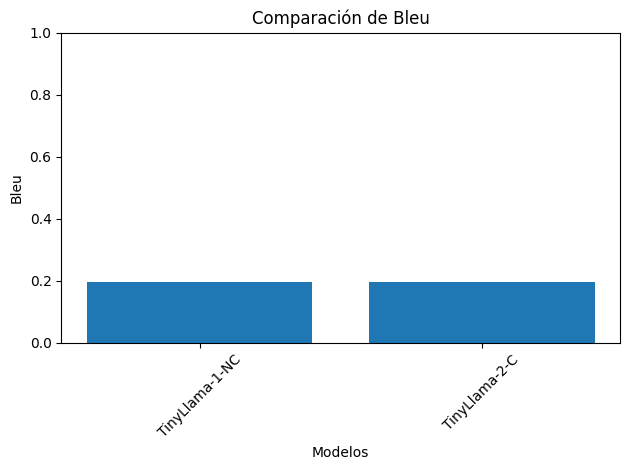

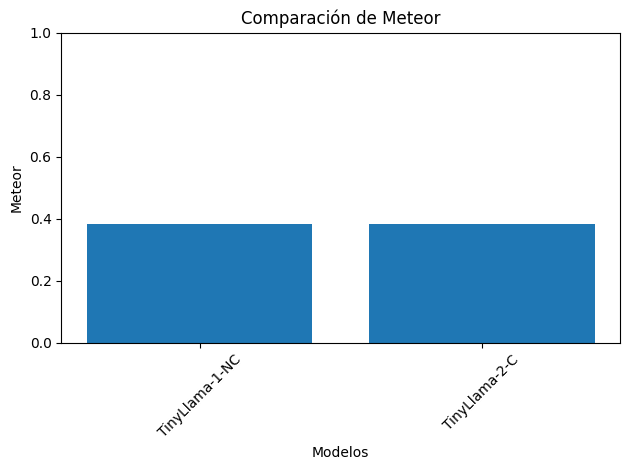

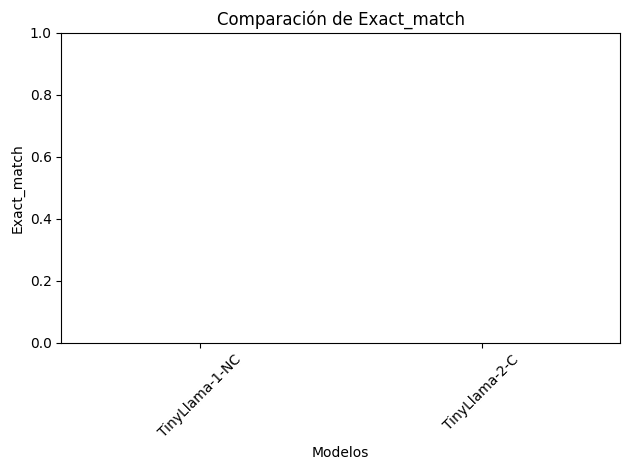

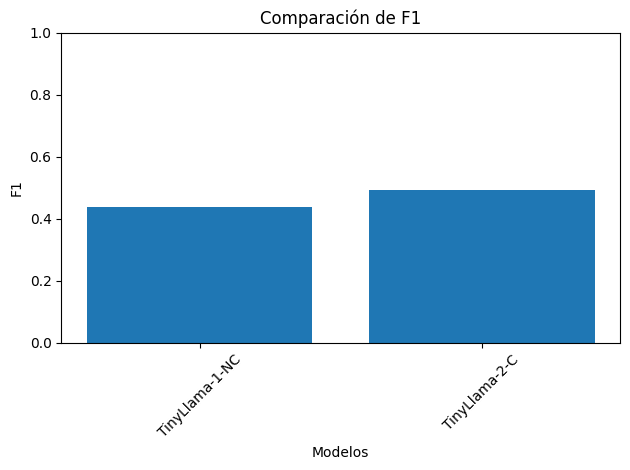

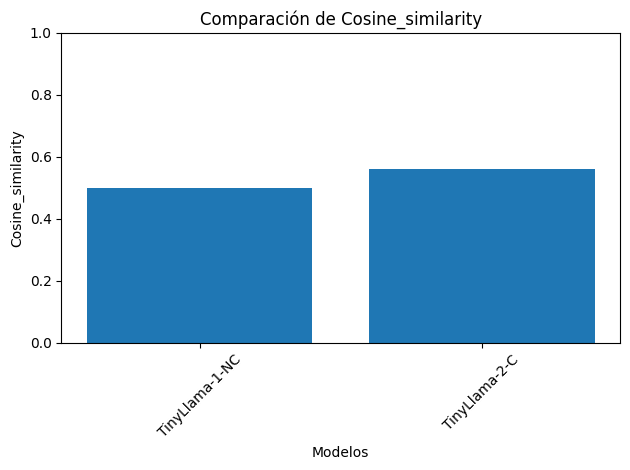

In [30]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "finqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break

model = LLMModel()
models = [
    ("TinyLlama-1-NC", model, False),
    ("TinyLlama-2-C", model, True)
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)